In [1]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import pandas
import seaborn
seaborn.set_style("darkgrid")

# Project imports
from legacy_model import *

In [2]:
# Get raw data
raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")

In [3]:
# Reset output file timestamp per run
file_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Reset seed per run
numpy.random.seed(0)

# Setup training time period
min_training_years = 25
baseline_window = 20
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max()+1)

# Setup model
m = None
term_count = 0

# Iterate over all terms
for term in term_range:
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    baseline_train_index = ((raw_data.loc[:, "term"] < term) & (raw_data.loc[:, "term"] >= (term-baseline_window))).values
    test_index = (raw_data.loc[:, "term"] == term).values
    
    if test_index.sum() == 0:
        continue
    
    # Fit the "baseline" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(numpy.zeros_like(raw_data.loc[baseline_train_index, :]), 
          (raw_data.loc[baseline_train_index, "justice_outcome_disposition"]).astype(int))
    
    # Store baseline predictions
    raw_data.loc[test_index, "baseline_predicted"] = d.predict(numpy.zeros_like(raw_data.loc[test_index, :]))

### Justice Accuracy - Other/Affirm/Reverse

In [4]:
# Get index and outcomes
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"]).astype(int)
target_baseline = raw_data.loc[evaluation_index, "baseline_predicted"].astype(int)
raw_data.loc[evaluation_index, "baseline_correct"] = (target_actual == target_baseline).astype(int)

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_baseline))
print(sklearn.metrics.confusion_matrix(target_actual, target_baseline))
print(sklearn.metrics.accuracy_score(target_actual, target_baseline))
print("="*32)
print("")

Dummy model
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00     39540
          0       0.51      0.79      0.62    113666
          1       0.57      0.44      0.49     93569

avg / total       0.45      0.53      0.47    246775

[[    0 32906  6634]
 [    0 89671 23995]
 [    0 52777 40792]]
0.528671867085



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


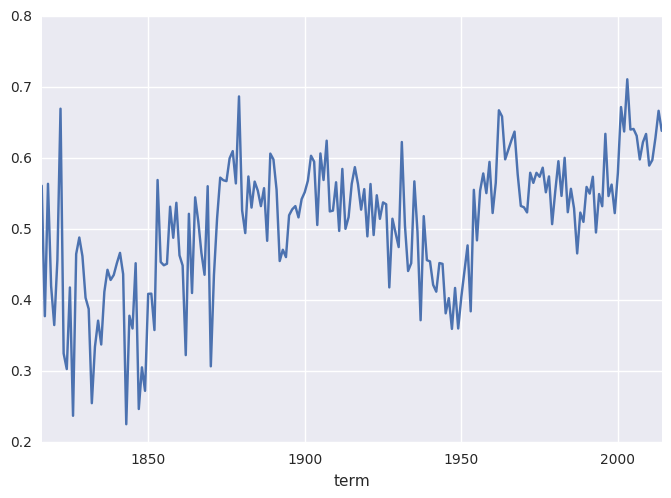

In [5]:
# Plot by term
baseline_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["baseline_correct"].mean()
baseline_correct_ts.plot()

### Justice Accuracy - Reverse/Not-Reverse

In [6]:
# Get index and outcomes
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
reverse_target_actual = (raw_data.loc[evaluation_index, "justice_outcome_disposition"] > 0).astype(int)
reverse_target_baseline = (raw_data.loc[evaluation_index, "baseline_predicted"] > 0).astype(int)
raw_data.loc[evaluation_index, "baseline_reverse_correct"] = (reverse_target_actual == reverse_target_baseline).astype(int)

# Dummy model
print("Dummy model - Reverse")
print("="*32)
print(sklearn.metrics.classification_report(reverse_target_actual, reverse_target_baseline))
print(sklearn.metrics.confusion_matrix(reverse_target_actual, reverse_target_baseline))
print(sklearn.metrics.accuracy_score(reverse_target_actual, reverse_target_baseline))
print("="*32)
print("")

Dummy model - Reverse
             precision    recall  f1-score   support

          0       0.70      0.80      0.75    153206
          1       0.57      0.44      0.49     93569

avg / total       0.65      0.66      0.65    246775

[[122577  30629]
 [ 52777  40792]]
0.662016006484



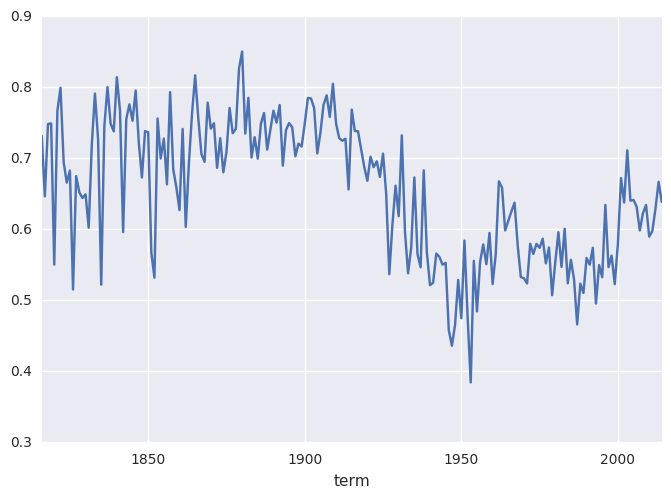

In [7]:
# Plot by term
baseline_reverse_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["baseline_reverse_correct"].mean()
baseline_reverse_correct_ts.plot()

### Case Accuracy - Reverse/Not-Reverse

In [8]:
# Get actual and predicted case outcomes
raw_data.loc[:, "justice_outcome_disposition_reverse"] = (raw_data.loc[evaluation_index, "justice_outcome_disposition"] > 0).astype(int)
raw_data.loc[:, "baseline_predicted_reverse"] = (raw_data.loc[evaluation_index, "baseline_predicted"] > 0).astype(int)
docket_baseline_predicted_reverse = (raw_data.loc[evaluation_index, :].groupby("docketId")["baseline_predicted_reverse"].mean() > 0.5).astype(int)
docket_actual_reverse = (raw_data.loc[evaluation_index, :].groupby("docketId")["case_outcome_disposition"].mean() > 0.5).astype(int)


# Dummy model
print("Dummy model - Reverse")
print("="*32)
print(sklearn.metrics.classification_report(docket_actual_reverse, docket_baseline_predicted_reverse))
print(sklearn.metrics.confusion_matrix(docket_actual_reverse, docket_baseline_predicted_reverse))
print("Accuracy:")
print(sklearn.metrics.accuracy_score(docket_actual_reverse, docket_baseline_predicted_reverse))
print("="*32)
print("")

Dummy model - Reverse
             precision    recall  f1-score   support

          0       0.69      0.83      0.75     16740
          1       0.64      0.45      0.53     11340

avg / total       0.67      0.67      0.66     28080

[[13842  2898]
 [ 6265  5075]]
Accuracy:
0.673682336182



In [9]:
# Create merged docket dataframe
docket_df = pandas.concat([docket_actual_reverse, docket_baseline_predicted_reverse], axis=1)
docket_df.columns = ["outcome_actual", "outcome_predicted"]
docket_df.loc[:, "baseline_reverse_correct"] = (docket_df["outcome_actual"] == docket_df["outcome_predicted"]).astype(int)
docket_df = docket_df.join(raw_data.loc[evaluation_index, ["docketId", "term"]].groupby("docketId")["term"].mean())
docket_df.head()

,outcome_actual,outcome_predicted,baseline_reverse_correct,term
docketId,,,,
1816-001-01,0,0,1,1816
1816-002-01,0,0,1,1816
1816-003-01,0,0,1,1816
1816-004-01,0,0,1,1816
1816-005-01,0,0,1,1816


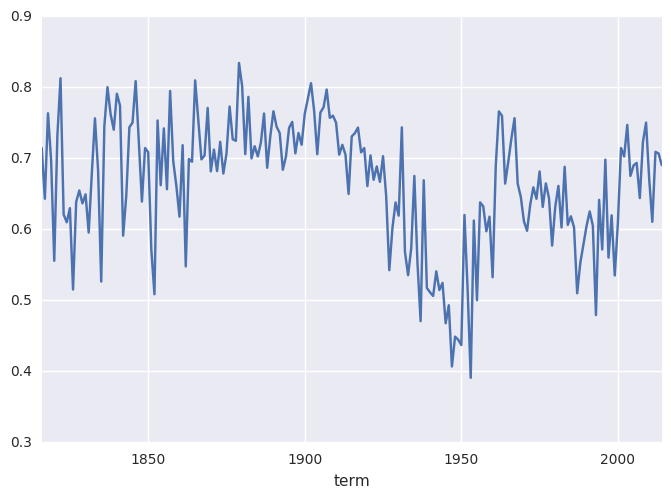

In [10]:
# Plot by term
baseline_case_reverse_correct_ts = docket_df.groupby("term")["baseline_reverse_correct"].mean()
baseline_case_reverse_correct_ts.plot()

In [11]:
# Output model results
raw_data.to_csv("../data/output/raw_docket_justice_baseline_model_most_frequent_20.csv.gz", compression="gzip")